In [1]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import (
    AutoTokenizer, AutoConfig,
    Trainer, TrainingArguments, TrainerCallback
)
from transformers import BertForSequenceClassification

c:\Users\loicm\miniconda3\envs\DeepLearningProject\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from transformers import TrainerCallback
import matplotlib.pyplot as plt
from IPython.display import clear_output

class LivePlotCallback(TrainerCallback):
    def __init__(self):
        self.epochs = []
        self.accuracies = []
        self.f1s = []

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        if metrics:
            self.epochs.append(state.epoch)
            self.accuracies.append(metrics.get("eval_accuracy", 0))
            self.f1s.append(metrics.get("eval_f1", 0))

            clear_output(wait=True)
            plt.figure(figsize=(8, 5))
            plt.plot(self.epochs, self.accuracies, label="Accuracy")
            plt.plot(self.epochs, self.f1s, label="F1 Score")
            plt.xlabel("Epoch")
            plt.ylabel("Score")
            plt.title("Live Evaluation Metrics")
            plt.legend()
            plt.grid(True)
            plt.show()

## 1. Load data

In [3]:
df = pd.read_csv("processed_contextual_data.csv")

## 2. Inject emotion into input text

In [4]:
df["input_text"] = df.apply(lambda row: f"[EMO] {row['emotion']} {row['text_with_context']}", axis=1)

In [5]:
texts = df["input_text"].tolist()
labels = df["label"].tolist()

## 3. Split data

In [6]:
texts_train, texts_test, labels_train, labels_test = train_test_split(
    texts, labels, test_size=0.1, random_state=42
)

## 4. Tokenizer

In [7]:
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

## 5. Tokenize

In [8]:
train_encodings = tokenizer(texts_train, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(texts_test, truncation=True, padding=True, max_length=512)

## 6. PyTorch Dataset

In [9]:
class HateDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

In [10]:
train_dataset = HateDataset(train_encodings, labels_train)
test_dataset = HateDataset(test_encodings, labels_test)

In [11]:
# Compute class weights
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(labels), y=labels)
print("Class weights:", class_weights)

Class weights: [0.7483846  1.50650364]


## 7. Model

In [12]:
class CustomBERT(BertForSequenceClassification):
    def __init__(self, config, class_weights):
        super().__init__(config)
        self.class_weights = torch.tensor(class_weights, dtype=torch.float)

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights.to(model.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [13]:

# Model
config = AutoConfig.from_pretrained(checkpoint, num_labels=2)
model = CustomBERT.from_pretrained(checkpoint, config=config, class_weights=class_weights)

Some weights of CustomBERT were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 8. Metrics

In [14]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

## 9. Training arguments

In [15]:
# Training args
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
)


c:\Users\loicm\miniconda3\envs\DeepLearningProject\lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


## 10. Trainer

In [16]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[LivePlotCallback()],
)

C:\Users\loicm\AppData\Local\Temp\ipykernel_31504\2177575764.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


## 11. Train

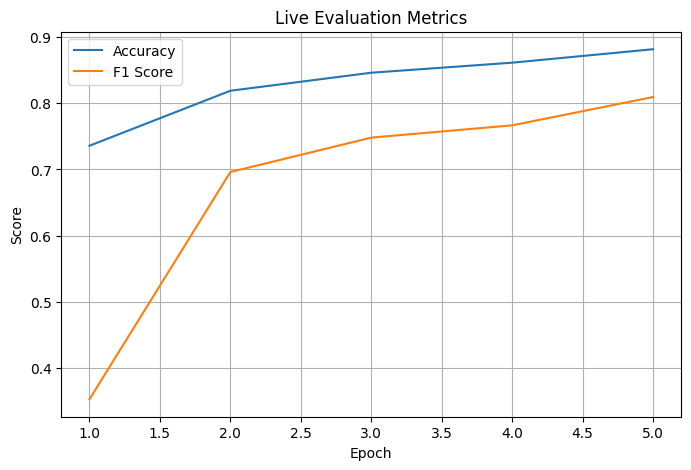

TrainOutput(global_step=16290, training_loss=0.4318001608383151, metrics={'train_runtime': 3940.3156, 'train_samples_per_second': 33.067, 'train_steps_per_second': 4.134, 'total_flos': 2.30332556749944e+16, 'train_loss': 0.4318001608383151, 'epoch': 5.0})

In [17]:
trainer.train()

## 12. Graph

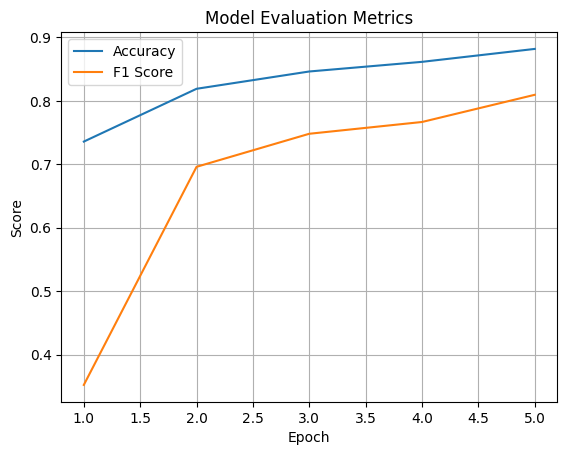

In [18]:
import matplotlib.pyplot as plt

# Récupérer les logs
logs = trainer.state.log_history

# Filtrer uniquement les logs d'évaluation
eval_logs = [x for x in logs if 'eval_loss' in x]

# Tracer
epochs = [x['epoch'] for x in eval_logs]
accuracies = [x['eval_accuracy'] for x in eval_logs]
f1s = [x['eval_f1'] for x in eval_logs]

plt.figure()
plt.plot(epochs, accuracies, label="Accuracy")
plt.plot(epochs, f1s, label="F1 Score")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Model Evaluation Metrics")
plt.legend()
plt.grid(True)
plt.show()

In [19]:
# print the metric final
print("Final Accuracy:", accuracies[-1])
print("Final F1 Score:", f1s[-1])


Final Accuracy: 0.8819060773480663
Final F1 Score: 0.8095768374164811


In [20]:
# debugging
import collections
print(collections.Counter(labels))


Counter({0: 19345, 1: 9610})


## 12. Save

In [21]:
model.save_pretrained("./my_hate_model")
tokenizer.save_pretrained("./my_hate_model")

('./my_hate_model\\tokenizer_config.json',
 './my_hate_model\\special_tokens_map.json',
 './my_hate_model\\vocab.txt',
 './my_hate_model\\added_tokens.json',
 './my_hate_model\\tokenizer.json')